# Experiment of Housing prices dataset

Obtained from: 
https://my.spindices.com/indices/real-estate/sp-corelogic-case-shiller-20-city-composite-home-price-nsa-index

In [1]:
# execute if not installed
import sys
sys.path.insert(0, '../')

import mogptk

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

%reload_ext autoreload
%autoreload 2

In [2]:
# plot config
sns.set_context('paper', font_scale=1.3)
sns.set_style('ticks')
plt.rcParams['figure.figsize'] = (10, 5)

In [3]:
def test_errors(model):
    """
    Obtain test errors for model
    
    The function assumes the original data includes the test data
    """
    x_pred = {i:array[stop:] for i, array in enumerate(model.data.X_all)}
    
    y_pred, var_pred = model.predict(x_pred)
    
    n_channels = model.data.get_output_dims()
    
    mae = np.zeros(n_channels)
    mape = np.zeros(n_channels)
    mse = np.zeros(n_channels)
    
    for i in range(n_channels):
        idx = model.data.Y_all[i] != 0
        y_true = model.data.Y_all[i][stop:]
        
        mae[i] = np.abs(y_true - y_pred[i]).mean()
        mape[i] = np.abs((y_true - y_pred[i]) / y_true).mean()
        mse[i] = ((y_true - y_pred[i])**2).mean()
    return mae, mape, mse

In [4]:
def plot_experiment(model, ylims=None, names=[], trends=None, title='Finance experiment'):
    """
    Plot finance exchange mogptk experiment
    """
    x_train = model.data.X
    y_train = model.data.Y
    x_all = model.data.X_all
    y_all = model.data.Y_all
    x_pred = {i:array for i, array in enumerate(data.X_all)}

    mean_pred, var_pred = model.predict(x_pred)
    
    f, axarr = plt.subplots(3, 2, sharex=True, figsize=(20, 15))
    axarr = axarr.reshape(-1)
    
    if trends is None:
    
        for i in range(len(x_train)):
            axarr[i].plot(x_train[i][:, 0], y_train[i], '.k', label='Train', )
            axarr[i].plot(x_all[i][:, 0], y_all[i], '--', label='Test', c='gray')

            axarr[i].plot(x_pred[i][:, 0], mean_pred[i], label='Pred', c=sns.color_palette()[i%10])
            axarr[i].fill_between(x_pred[i][:, 0].reshape(-1),
                                  mean_pred[i] + 2 * np.sqrt(var_pred[i]),
                                  mean_pred[i] - 2 * np.sqrt(var_pred[i]),
                                  label='95% c.i',
                                  color=sns.color_palette()[i%10],
                                  alpha=0.4)

            axarr[i].legend(ncol=4)
            axarr[i].set_title(names[i])
            axarr[i].set_xlim(-1, x_all[i][-1])
    else:
        for i in range(len(x_train)):
            t = np.polyval(trends[i], x_train[i][:, 0].reshape(-1))
            axarr[i].plot(x_train[i][:, 0], y_train[i] + t,'.k', label='Train', )
            
            t = np.polyval(trends[i], x_all[i][:, 0].reshape(-1))
            axarr[i].plot(x_all[i][:, 0], y_all[i] + t, '--', label='Test', c='gray')

            t = np.polyval(trends[i], x_pred[i][:, 0].reshape(-1))
            axarr[i].plot(x_pred[i][:, 0], mean_pred[i] + t, label='Pred', c=sns.color_palette()[i%10])
            axarr[i].fill_between(x_pred[i][:, 0].reshape(-1),
                                  mean_pred[i]  + t + 2 * np.sqrt(var_pred[i]),
                                  mean_pred[i] + t - 2 * np.sqrt(var_pred[i]),
                                  label='95% c.i',
                                  color=sns.color_palette()[i%10],
                                  alpha=0.4)

            axarr[i].legend(ncol=4)
            axarr[i].set_title(names[i])
            axarr[i].set_xlim(-1, x_all[i][-1])
        
    plt.suptitle(title, y=1.02)
    plt.tight_layout()

### Load dataset

In [5]:
# load dataset 
cols = ['Chicago', 'Phoenix', 'Los Angeles', 'San Diego', 'New York', 'San Francisco']

df = pd.read_csv('data/finance_datasets/housing_prices_usa/housing_dataset.csv',
                 skiprows=7,
                 names=cols)
df = df.iloc[:-4]
df.index = pd.to_datetime(df.index)

df['Month'] = np.round(((df.index - df.index[0]) / np.timedelta64(1, 'M')).values)
df.head()

,Chicago,Phoenix,Los Angeles,San Diego,New York,San Francisco,Month
2009-05-01,123.73,103.56,159.18,145.06,171.17,120.16,0.0
2009-06-01,124.99,104.73,160.90,147.31,172.34,124.70,1.0
2009-07-01,128.32,106.66,163.97,150.99,173.91,128.86,2.0
2009-08-01,130.55,108.41,166.62,153.34,175.13,132.47,3.0
2009-09-01,132.13,109.26,168.03,154.76,174.81,134.16,4.0


### Data

In [6]:
data = mogptk.Data()

trend_list = []

for i, c in enumerate(cols):
    x = df['Month'].values
    y_old = df[c].values
    # y = np.log(df[c].values)
    
    # detrend 
    pol = np.polyfit(x, y_old, 1)
    trend_list.append(pol)
    y = y_old - np.polyval(pol, x)
    
    data.add(x.reshape(-1, 1), y)
    
    stop = int(len(df) * 0.9)
    data.remove_range(i, df['Month'][stop], None)

### Model 

In [7]:
n_trials = 1

mosm_mae = np.zeros((n_trials, len(cols)))
mosm_mape = np.zeros((n_trials, len(cols)))
mosm_mse = np.zeros((n_trials, len(cols)))

for n in range(n_trials):
    print('Trial ', n)
    model = mogptk.MOSM(data, Q=5)
    # model.init_params('means')
    
    model.train(method='Adam', maxiter=3000, tol=1e-50)
    
    mae, mape, mse = test_errors(model)
    
    mosm_mae[n, :] = mae
    mosm_mape[n, :] = mape
    mosm_mse[n, :] = mse

pd.DataFrame(np.c_[mosm_mae.mean(0), mosm_mape.mean(0), mosm_mse.mean(0),
                             mosm_mae.std(0), mosm_mape.std(0), mosm_mse.std(0)],
                       columns=['MAE', 'MAPE', 'MSE', 'MAE std', 'MAPE% std', 'MSE std'])

Trial  0
Done in  6.653377230962118  minutes


,MAE,MAPE,MSE,MAE std,MAPE% std,MSE std
0,2.641163,0.915830,9.106217,0.0,0.0,0.0
1,2.077311,1.019067,5.025823,0.0,0.0,0.0
2,2.455236,0.851857,7.430826,0.0,0.0,0.0
3,2.831804,1.214440,10.413346,0.0,0.0,0.0
4,5.947818,0.935092,38.734088,0.0,0.0,0.0
5,4.929264,0.911534,30.628024,0.0,0.0,0.0


In [15]:
y_test = [y[stop:] for y in data.Y_all]
x_test = {i:array[stop:] for i, array in enumerate(data.X_all)}

errors = mogptk.test_errors(model, x_test=x_test, y_test=y_test, raw_errors=True)

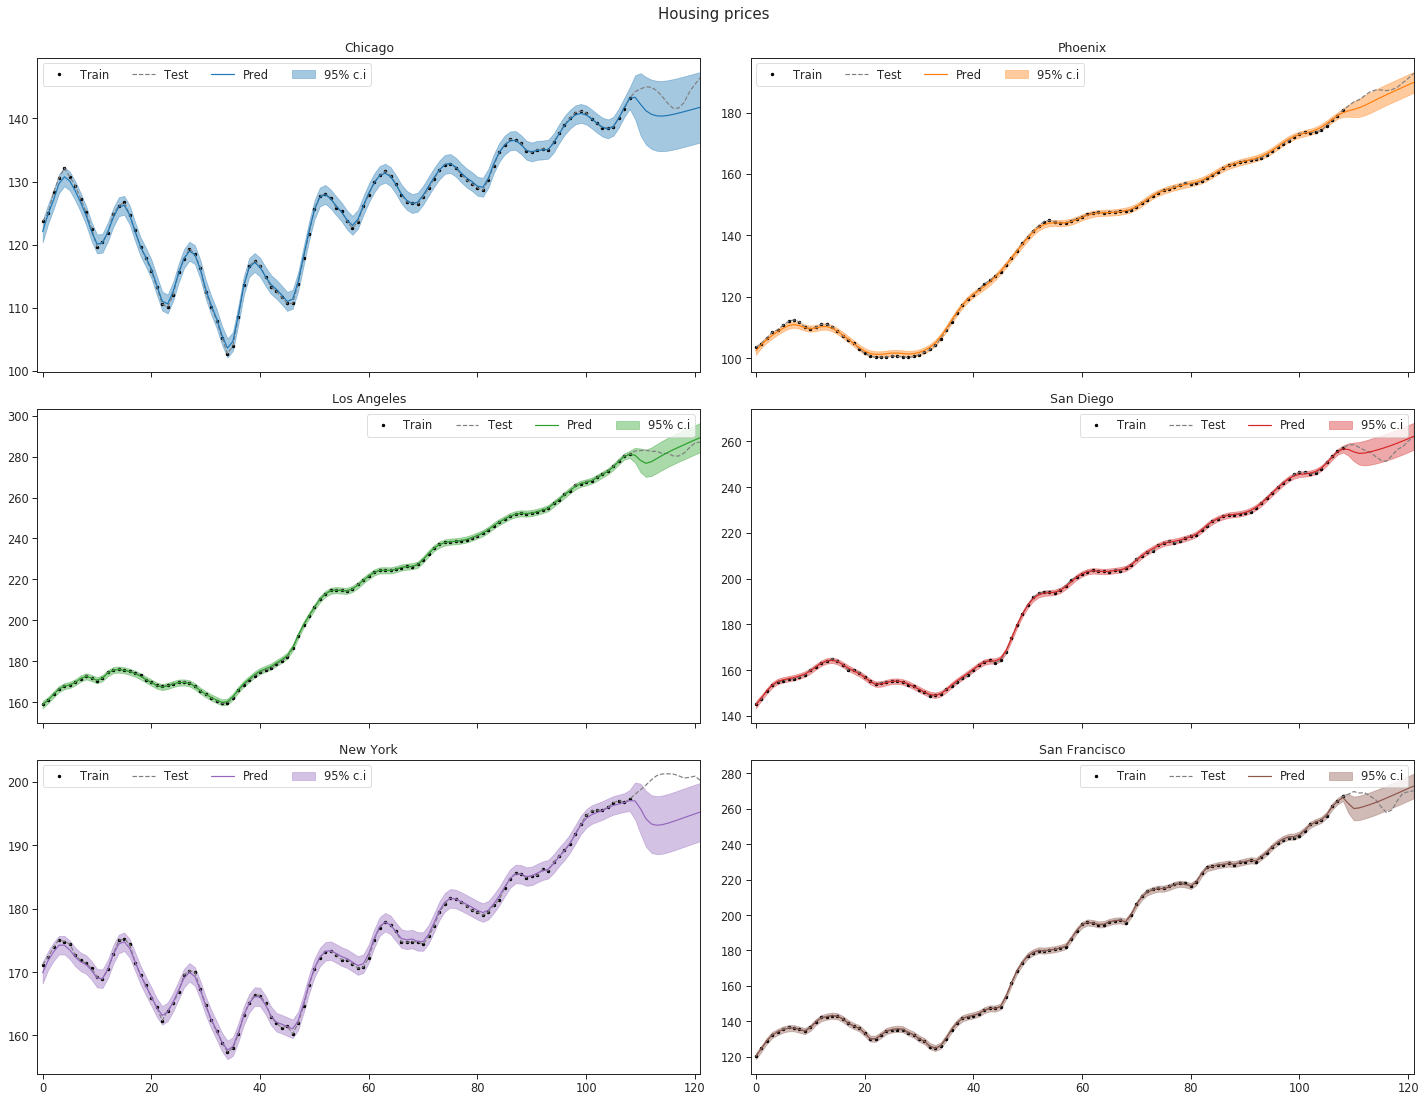

In [8]:
plot_experiment(model, names=cols, trends=trend_list, title='Housing prices')

## CSM

In [9]:
n_trials = 10

csm_mae = np.zeros((n_trials, len(cols)))
csm_mape = np.zeros((n_trials, len(cols)))
csm_mse = np.zeros((n_trials, len(cols)))

for n in range(n_trials):
    print('Trial ', n)
    model = mogptk.CSM(data, Q=5)
    # model.init_params()
    
    model.train(method='Adam', maxiter=3000, tol=1e-50)
    
    mae, mape, mse = test_errors(model)
    
    csm_mae[n, :] = mae
    csm_mape[n, :] = mape
    csm_mse[n, :] = mse

pd.DataFrame(np.c_[csm_mae.mean(0), csm_mape.mean(0), csm_mse.mean(0),
                             csm_mae.std(0), csm_mape.std(0), csm_mse.std(0)],
                       columns=['MAE', 'MAPE', 'MSE', 'MAE std', 'MAPE% std', 'MSE std'])

Trial  0
Done in  2.6392064770062764  minutes
Trial  1
Done in  2.507835392157237  minutes
Trial  2
Done in  2.4608958045641582  minutes
Trial  3
Done in  2.4941272020339964  minutes
Trial  4
Done in  2.4814497311909993  minutes
Trial  5
Done in  2.840749760468801  minutes
Trial  6
Done in  2.4385053277015687  minutes
Trial  7
Done in  2.5358421444892882  minutes
Trial  8
Done in  2.4749208092689514  minutes
Trial  9
Done in  2.461795151233673  minutes


,MAE,MAPE%,MSE,MAE std,MAPE% std,MSE std
0,2.556108,0.838802,8.566434,0.306677,0.100094,1.755897
1,1.707219,0.843597,3.734094,0.146981,0.059955,0.563554
2,2.464139,0.850292,7.704390,0.272044,0.061125,1.556237
3,2.717057,0.900881,10.035690,0.251648,0.087383,1.706477
4,5.598497,0.880045,33.961123,0.306965,0.045705,3.198703
5,4.913502,0.886878,31.029916,0.336733,0.047324,4.196670


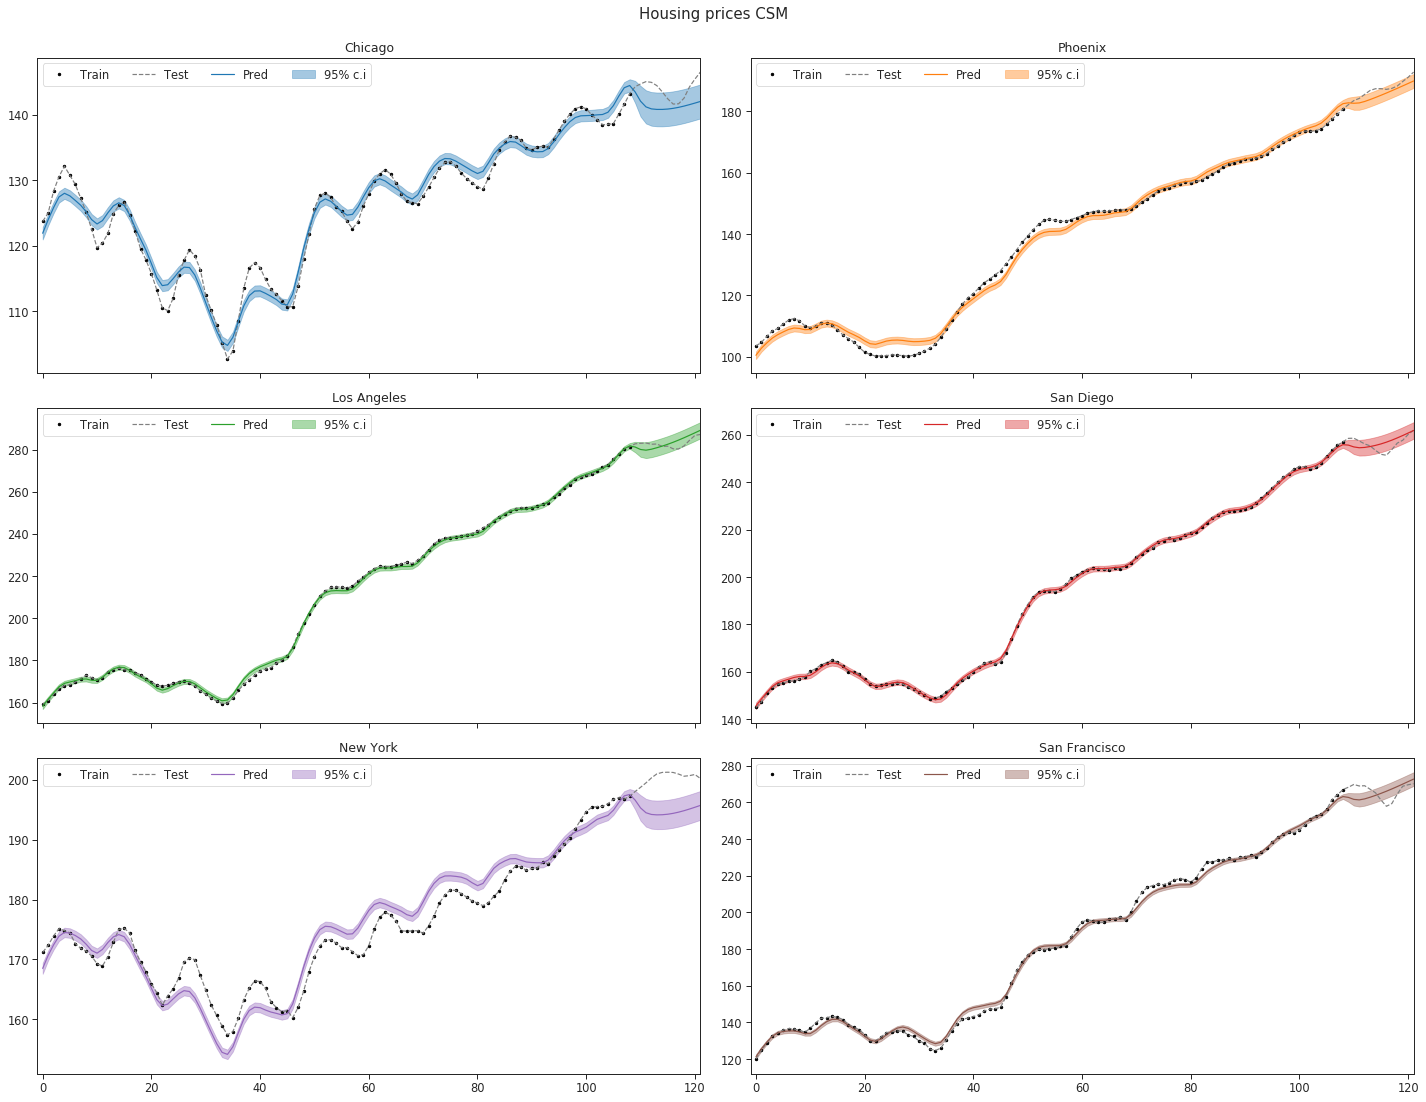

In [10]:
plot_experiment(model, names=cols, trends=trend_list, title='Housing prices CSM')

## SM LMC

In [11]:
n_trials = 10

smlmc_mae = np.zeros((n_trials, len(cols)))
smlmc_mape = np.zeros((n_trials, len(cols)))
smlmc_mse = np.zeros((n_trials, len(cols)))

for n in range(n_trials):
    print('Trial ', n)
    model = mogptk.SM_LMC(data, Q=5)
    # model.init_params()
    
    model.train(method='Adam', maxiter=3000, tol=1e-50)
    
    mae, mape, mse = test_errors(model)
    
    smlmc_mae[n, :] = mae
    smlmc_mape[n, :] = mape
    smlmc_mse[n, :] = mse

pd.DataFrame(np.c_[smlmc_mae.mean(0), smlmc_mape.mean(0), smlmc_mse.mean(0),
                   smlmc_mae.std(0), smlmc_mape.std(0), smlmc_mse.std(0)],
             columns=['MAE', 'MAPE', 'MSE', 'MAE std', 'MAPE% std', 'MSE std'])

Trial  0
Done in  2.0119200269381206  minutes
Trial  1
Done in  1.9813876191775004  minutes
Trial  2
Done in  1.973133393128713  minutes
Trial  3
Done in  1.986226232846578  minutes
Trial  4
Done in  2.0185653805732726  minutes
Trial  5
Done in  2.077533026536306  minutes
Trial  6
Done in  2.0674361189206443  minutes
Trial  7
Done in  1.9923869212468466  minutes
Trial  8
Done in  1.9848270694414774  minutes
Trial  9
Done in  1.9867183089256286  minutes


,MAE,MAPE%,MSE,MAE std,MAPE% std,MSE std
0,2.668314,0.884900,9.509552,0.544175,0.139555,2.981508
1,1.783844,0.871553,4.539855,0.519787,0.228201,2.738688
2,2.612536,0.900908,8.840983,0.402427,0.107632,2.685282
3,2.869268,0.931442,11.305479,0.297329,0.135641,2.295754
4,5.824691,0.914227,36.709629,0.473325,0.070053,5.462355
5,4.762873,0.876559,29.412941,0.374162,0.048142,4.721653


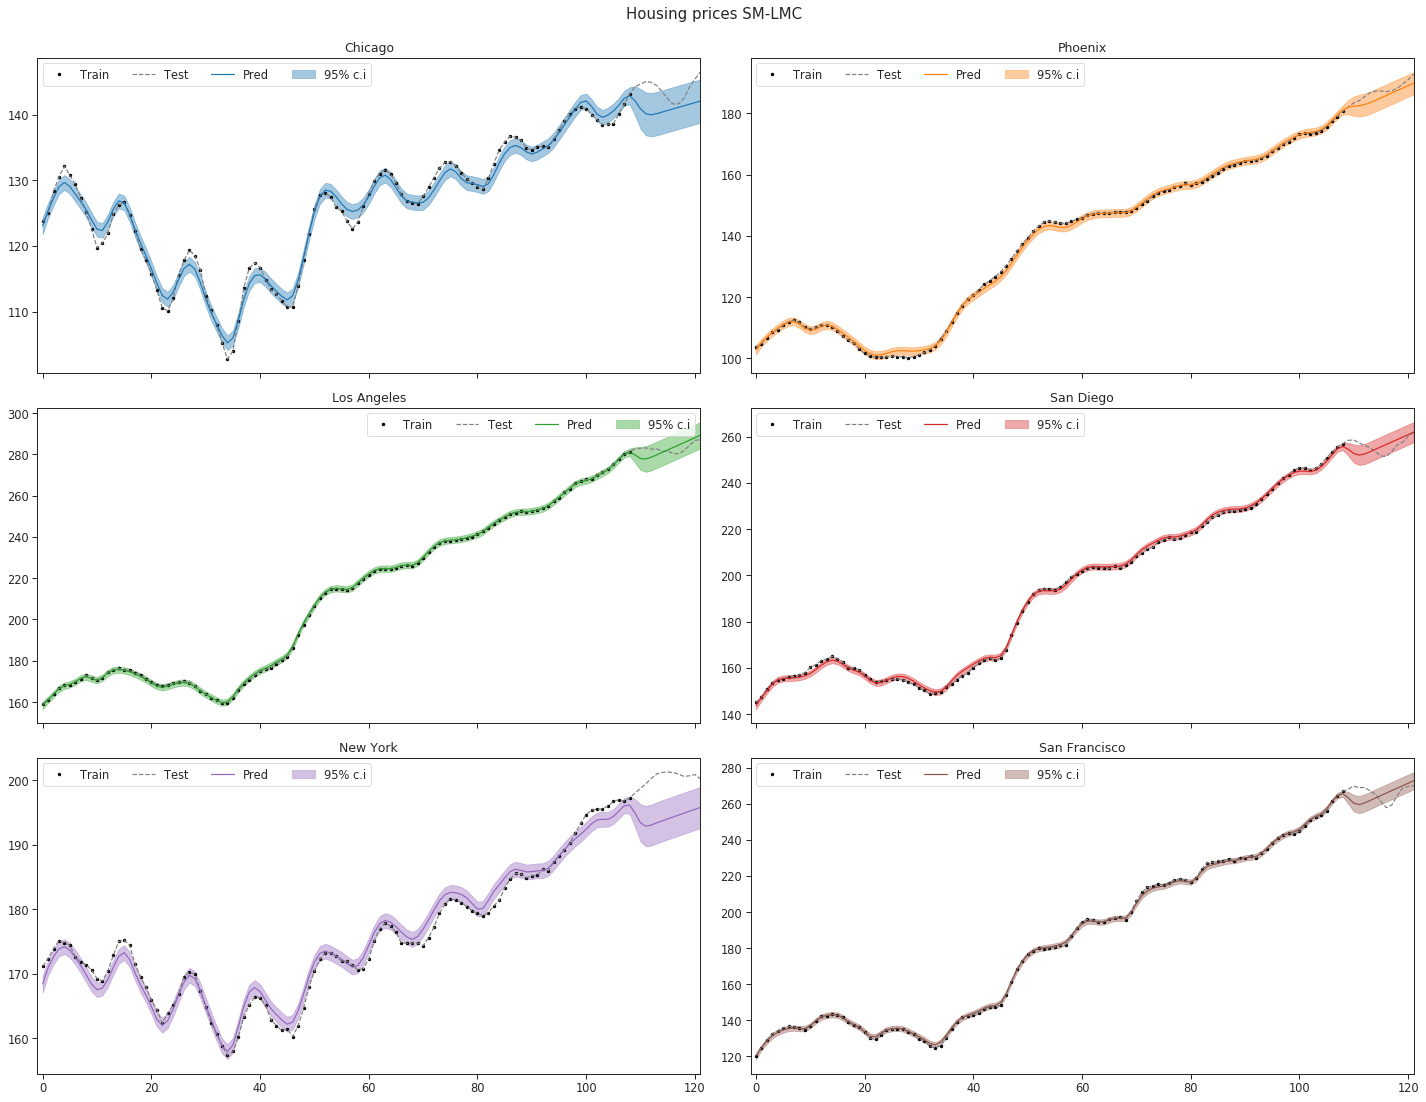

In [12]:
plot_experiment(model, names=cols, trends=trend_list, title='Housing prices SM-LMC')

In [13]:
print(mosm_mape.mean(), csm_mape.mean(), smlmc_mape.mean())

1.0394107934840116 0.8667491466062821 0.8965981149350861


In [14]:
print(mosm_mse.mean(), csm_mse.mean(), smlmc_mse.mean())

18.56427681726196 15.838608008118118 16.719739745743578


In [15]:
print(mosm_mae.mean(), csm_mae.mean(), smlmc_mae.mean())

3.639470402230768 3.326086954507941 3.4202542116173307
